<a href="https://colab.research.google.com/github/MahmoudAlsayes/pythonProject/blob/master/04_transfer_learning_in_tensorflow_part1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Tranfer learning with tensorflow part1 : Feature Extraction

In [ ]:
# Are we used a gpu
!nvidia-smi

Fri Sep  6 18:08:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Download and becomimg one with data set

In [ ]:
#Get data(10%)
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip
zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-09-06 18:08:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  34.7MB/s    in 5.6s    

2024-09-06 18:08:48 (28.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many image in eatch folder?
import os
# Walk through 10 percent
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in'{dirpath}.'")

There are 2 directories and 0 images in'10_food_classes_10_percent.'
There are 10 directories and 0 images in'10_food_classes_10_percent/test.'
There are 0 directories and 250 images in'10_food_classes_10_percent/test/grilled_salmon.'
There are 0 directories and 250 images in'10_food_classes_10_percent/test/ice_cream.'
There are 0 directories and 250 images in'10_food_classes_10_percent/test/ramen.'
There are 0 directories and 250 images in'10_food_classes_10_percent/test/steak.'
There are 0 directories and 250 images in'10_food_classes_10_percent/test/pizza.'
There are 0 directories and 250 images in'10_food_classes_10_percent/test/hamburger.'
There are 0 directories and 250 images in'10_food_classes_10_percent/test/sushi.'
There are 0 directories and 250 images in'10_food_classes_10_percent/test/fried_rice.'
There are 0 directories and 250 images in'10_food_classes_10_percent/test/chicken_wings.'
There are 0 directories and 250 images in'10_food_classes_10_percent/test/chicken_curry.

## Creating data loaders

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
EPOCHS=5

train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print("Traning images :")
train_data_10_percent=train_datagen.flow_from_directory(train_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

print("Testing images :")
test_data=test_datagen.flow_from_directory(test_dir,
                                           target_size=IMAGE_SHAPE,
                                           batch_size=BATCH_SIZE,
                                           class_mode="categorical")


Traning images :
Found 750 images belonging to 10 classes.
Testing images :
Found 2500 images belonging to 10 classes.


## setting up callbacks

In [ ]:
import tf_keras as tfk
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tfk.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-classification/2"




In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import tf_keras as tfk


In [ ]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url, trainable=False ,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tfk.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    tfk.layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

## Creating and testing ResNet Tensorflow Hub Feature Extraction model

In [ ]:
# Create Model
resnet_model=create_model(resnet_url,num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
ResNet_V2_50 = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-classification/2"
import tf_keras as tfk


In [ ]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tfk.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
resnet_history=resnet_model.fit(train_data_10_percent,epochs=5,validation_data=test_data,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="resnet50V2")]
                 )

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240906-180908
Epoch 1/5
24/24 [==============================] - 26s 743ms/step - loss: 1.8679 - accuracy: 0.3893 - val_loss: 1.1500 - val_accuracy: 0.6304
Epoch 2/5
24/24 [==============================] - 14s 600ms/step - loss: 0.8798 - accuracy: 0.7427 - val_loss: 0.8176 - val_accuracy: 0.7464
Epoch 3/5
24/24 [==============================] - 13s 557ms/step - loss: 0.6020 - accuracy: 0.8373 - val_loss: 0.7435 - val_accuracy: 0.7608
Epoch 4/5
24/24 [==============================] - 12s 533ms/step - loss: 0.4635 - accuracy: 0.8840 - val_loss: 0.6882 - val_accuracy: 0.7852
Epoch 5/5
24/24 [==============================] - 15s 625ms/step - loss: 0.3687 - accuracy: 0.9053 - val_loss: 0.6690 - val_accuracy: 0.7868


# Let's create loss curves


In [ ]:
# Create a function
# we can put this function like a script call "helper.py" and import it when you need
import matplotlib.pyplot as plt

# plot the validation and training curves
def plot_loss_curves(history):
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=range(len(history.history["loss"]))

  #plot the lodd
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

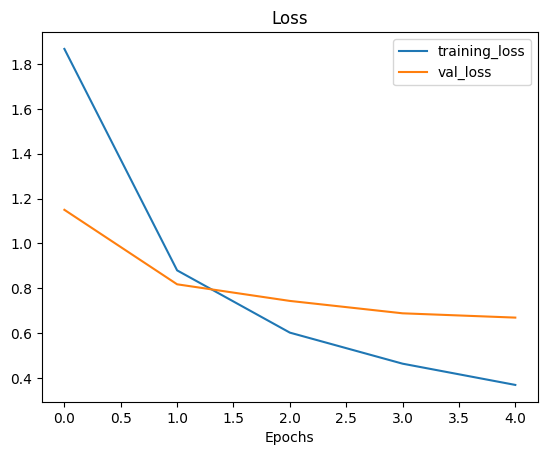

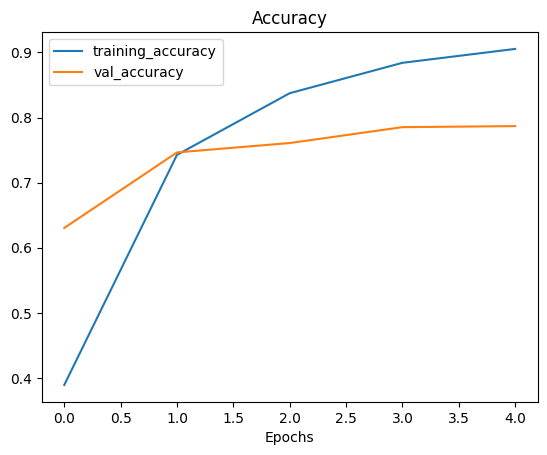

In [ ]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 Tensorflow Hub Feature Extraction model

In [ ]:
# Creat EffienetNetB0 feature extraction model
efficientnet_model=create_model(efficientnet_url,num_classes=train_data_10_percent.num_classes)

# Compile Effient
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tfk.optimizers.Adam(),
                           metrics=["accuracy"])

In [ ]:
# fit
efficientnet_history=efficientnet_model.fit(train_data_10_percent,
                       epochs=5,
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data,
                       validation_steps=len(test_data),
                       callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="efficientnetb0")]
                       )

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20240906-185454
Epoch 1/5
24/24 [==============================] - 10s 425ms/step - loss: 0.2505 - accuracy: 0.9613 - val_loss: 0.7108 - val_accuracy: 0.7664
Epoch 2/5
24/24 [==============================] - 12s 534ms/step - loss: 0.2401 - accuracy: 0.9680 - val_loss: 0.6730 - val_accuracy: 0.7756
Epoch 3/5
24/24 [==============================] - 12s 521ms/step - loss: 0.2091 - accuracy: 0.9707 - val_loss: 0.6928 - val_accuracy: 0.7688
Epoch 4/5
24/24 [==============================] - 9s 381ms/step - loss: 0.1849 - accuracy: 0.9787 - val_loss: 0.6859 - val_accuracy: 0.7780
Epoch 5/5
24/24 [==============================] - 12s 500ms/step - loss: 0.1781 - accuracy: 0.9800 - val_loss: 0.7187 - val_accuracy: 0.7684


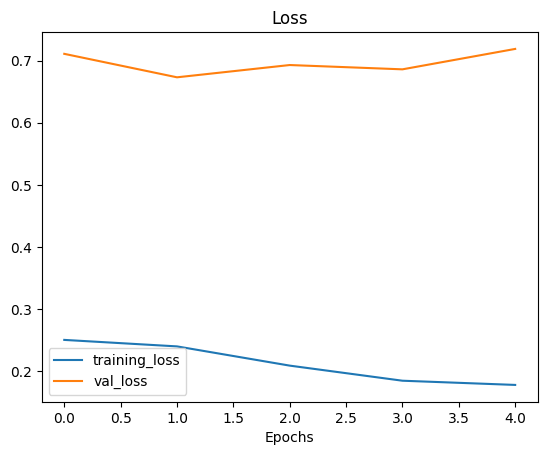

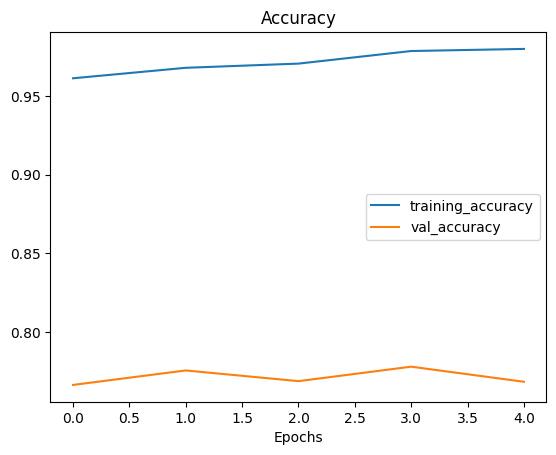

In [ ]:
plot_loss_curves(efficientnet_history)

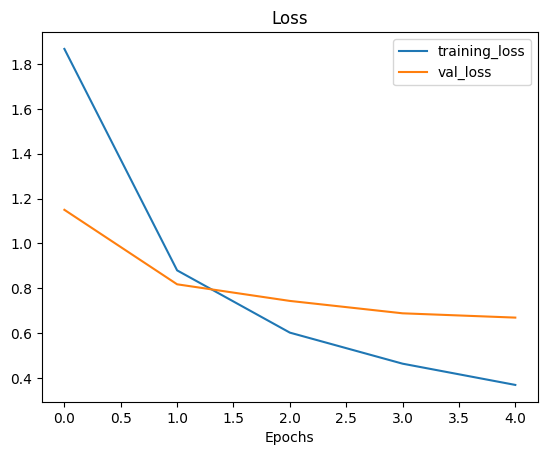

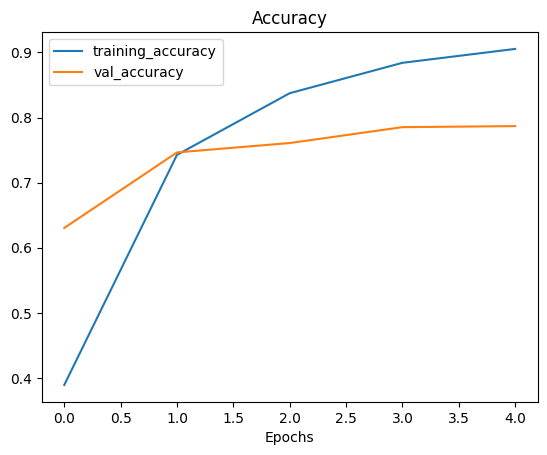

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1000)              7200312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                10010     
                                                                 
Total params: 7210322 (27.51 MB)
Trainable params: 10010 (39.10 KB)
Non-trainable params: 7200312 (27.47 MB)
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


#compair our models results using TensorBoard

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2024-09-06 19:53:24.766965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 19:53:24.787968: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 19:53:24.793901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 19:53:25.815674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.


In [ ]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

No known TensorBoard instances running.


In [ ]:
!docker run -it -p 8888:8888 -p 6006:6006 \
tensorflow/tensorflow:nightly-py3-jupyter

/bin/bash: line 1: docker: command not found


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard